# Data Pipeline / UN Genral Assembly Speeces

Original Data source: Jankin Mikhaylov, Slava; Baturo, Alexander; Dasandi, Niheer, 2017, "United Nations General Debate Corpus", https://doi.org/10.7910/DVN/0TJX8Y, Harvard Dataverse, V5
Further processing from "Blueprints for Text Analytics using Python"

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib as plt
import re

In [ ]:
# Tests to see if we are running in the Google Colaboratory environment
# If so, use an https URL to access the data.  Otherwise, load via the file path
try:
  import google.colab
  data_file_prefix = "https://raw.githubusercontent.com/slankas/DataScienceNotebooks/master/DataCleaning/"
  import plotly.io as pio
  pio.renderers.default = 'colab'
except:
  data_file_prefix = ""

In [2]:
pd.options.display.max_colwidth = 150

df = pd.read_csv(data_file_prefix + 'un-general-debates-blueprint.csv')

## Perform exploratory data analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


In [4]:
df['length'] = df['text'].str.len()

df.describe()

,session,year,length
count,7507.000000,7507.000000,7507.000000
mean,49.610763,1994.610763,17967.281604
std,12.892155,12.892155,7860.038463
min,25.000000,1970.000000,2362.000000
25%,39.000000,1984.000000,12077.000000
50%,51.000000,1996.000000,16424.000000
75%,61.000000,2006.000000,22479.500000
max,70.000000,2015.000000,72041.000000


In [5]:
ProfileReport(df).to_widgets()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df[['country', 'speaker']].describe(include='O').T

,count,unique,top,freq
country,7507,199,GTM,46
speaker,7480,5428,Seyoum Mesfin,12


Check for missing data

In [7]:
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [8]:
df['speaker'].fillna('unknown', inplace=True)


In [9]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
George Bush           1
Mr. George W Bush     1
Bush                  1
Name: speaker, dtype: int64

Notice that we have a data cleansing activity to perform here.

<AxesSubplot:>

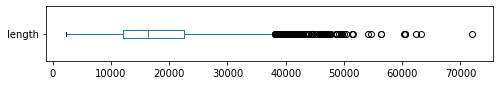

In [10]:
df['length'].plot(kind='box', vert=False, figsize=(8, 1))

50% of the speeches have a length between ~12,000 and ~22,000 words.  Median ~ 16,000.

long-tail distribution to the right

<AxesSubplot:ylabel='Frequency'>

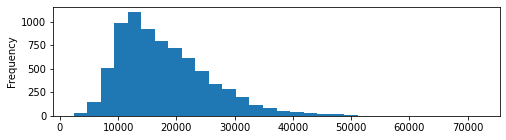

In [11]:
df['length'].plot(kind='hist', bins=30, figsize=(8,2))

/home/jbslanka/mypython/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


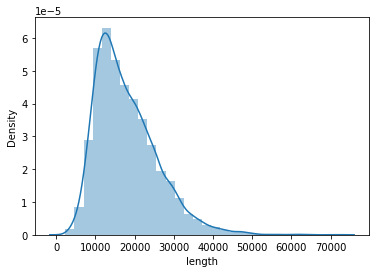

In [12]:

sns.distplot(df['length'], bins=30, kde=True);

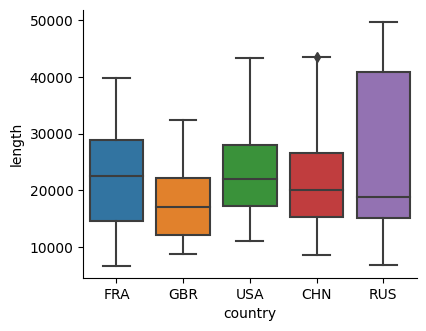

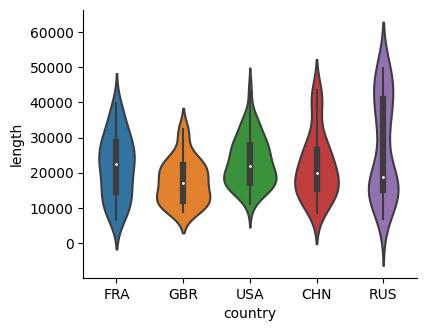

In [13]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="length", kind='box')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###
g = sns.catplot(data=df[where], x="country", y="length", kind='violin')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###

<AxesSubplot:title={'center':'Number of Countries'}, xlabel='year'>

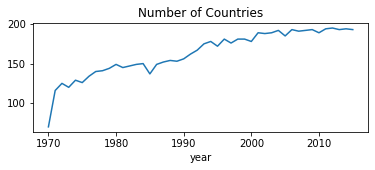

In [14]:
df.groupby('year').size().plot(title="Number of Countries", figsize=(6,2))

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

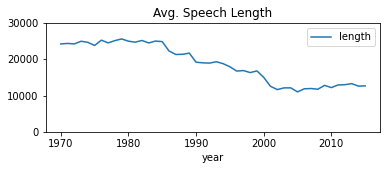

In [15]:
df.groupby('year').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2))

### Data Cleaning

In [16]:
df['speaker'].fillna('unkown', inplace=True)
df['position'].fillna('unkown', inplace=True)

In [17]:
print(repr(df.iloc[0]["text"][0:200]))
print(repr(df.iloc[-1]["text"][0:200]))

'33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work '
'Allow me at the outset to extend to Mr. Mogens Lykketoft my warm congratulations on his election to the high office of President of the General Assembly at its seventieth session. He assumes this offi'


In [18]:
df["text"]  =  df["text"].map(lambda text: re.sub(r"\d+:", "", text))
df["text"]  =  df["text"].map(lambda text: re.sub(r"\d+.", "", text))
df["text"]  =  df["text"].map(lambda text: re.sub(r"\t", " ", text))

In [19]:
print(repr(df.iloc[0]["text"][0:200]))
print(repr(df.iloc[-1]["text"][0:200]))

' May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n In taking up the work on the'
'Allow me at the outset to extend to Mr. Mogens Lykketoft my warm congratulations on his election to the high office of President of the General Assembly at its seventieth session. He assumes this offi'


## Character normalization with Textacy
https://textacy.readthedocs.io/

In [20]:
import textacy.preprocessing as tprep

def normalize(text):
    text = tprep.normalize_hyphenated_words(text)
    text = tprep.normalize_quotation_marks(text)
    text = tprep.normalize_unicode(text)
    text = tprep.remove_accents(text)
    return text

In [21]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."
print (normalize(text))

The cafe "Saint-Raphael" is located on Cote d'Azur.


## Stop words

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
example_sent = """Apple is looking at buying U.K. startup for $1 billion."""

# notice that this is just a normal python data structure now - we can add and remove words
stop_words = set(stopwords.words('english'))


word_tokens = word_tokenize(example_sent)
 
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
 
filtered_sentence = []
 
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
 
print(word_tokens)
print(filtered_sentence)

['Apple', 'is', 'looking', 'at', 'buying', 'U.K.', 'startup', 'for', '$', '1', 'billion', '.']
['Apple', 'looking', 'buying', 'U.K.', 'startup', '$', '1', 'billion', '.']


## Stemming
Rule driven approaches to derive root / base words

In [24]:
import nltk

from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()
words = ['run','runner','running','ran','runs','easily','fairly', 'universe','university']
for word in words:
    print(word+' --> '+p_stemmer.stem(word))

run --> run
runner --> runner
running --> run
ran --> ran
runs --> run
easily --> easili
fairly --> fairli
universe --> univers
university --> univers


In [25]:
from nltk.stem.snowball import SnowballStemmer

# The Snowball Stemmer requires that you pass a language parameter
s_stemmer = SnowballStemmer(language='english')

for word in words:
    print(word+' --> '+s_stemmer.stem(word))

run --> run
runner --> runner
running --> run
ran --> ran
runs --> run
easily --> easili
fairly --> fair
universe --> univers
university --> univers


In [26]:
print( [s_stemmer.stem(w) for w in filtered_sentence] )

['appl', 'look', 'buy', 'u.k.', 'startup', '$', '1', 'billion', '.']


## Lemmatization


In [27]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()
for word in words:
    print(word+' --> '+lemmatizer.lemmatize(word))

run --> run
runner --> runner
running --> running
ran --> ran
runs --> run
easily --> easily
fairly --> fairly
universe --> universe
university --> university


In [28]:
print("better :", lemmatizer.lemmatize("better", pos ="a"))
print("better :", lemmatizer.lemmatize("better", pos ="n"))

better : good
better : better


In [29]:
print( [lemmatizer.lemmatize(w) for w in filtered_sentence] )

['Apple', 'looking', 'buying', 'U.K.', 'startup', '$', '1', 'billion', '.']


In [30]:
# Lemmatization w/ Spacy
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [31]:
def show_lemmas(text):
    for token in text:
        print(f'{token.text:{12}} {token.pos_:{6}} {token.lemma:<{22}} {token.lemma_}')

In [32]:
doc = nlp(u"I saw eighteen mice today!")

show_lemmas(doc)

I            PRON   561228191312463089     -PRON-
saw          VERB   11925638236994514241   see
eighteen     NUM    9609336664675087640    eighteen
mice         NOUN   1384165645700560590    mouse
today        NOUN   11042482332948150395   today
!            PUNCT  17494803046312582752   !


In [33]:
doc = nlp(u"To be or is or was or whatever.")

show_lemmas(doc)

To           PART   3791531372978436496    to
be           AUX    10382539506755952630   be
or           CCONJ  3740602843040177340    or
is           AUX    10382539506755952630   be
or           CCONJ  3740602843040177340    or
was          AUX    10382539506755952630   be
or           CCONJ  3740602843040177340    or
whatever     DET    1407391887329900988    whatever
.            PUNCT  12646065887601541794   .


In [34]:
doc = nlp(u"Apple is looking at buying U.K. startup for $1 billion.")

show_lemmas(doc)

Apple        PROPN  6418411030699964375    Apple
is           AUX    10382539506755952630   be
looking      VERB   16096726548953279178   look
at           ADP    11667289587015813222   at
buying       VERB   9457496526477982497    buy
U.K.         PROPN  14409890634315022856   U.K.
startup      NOUN   7622488711881293715    startup
for          ADP    16037325823156266367   for
$            SYM    11283501755624150392   $
1            NUM    5533571732986600803    1
billion      NUM    1231493654637052630    billion
.            PUNCT  12646065887601541794   .


In [35]:
## Spacy Stop words

print (nlp.Defaults.stop_words)

{'ourselves', 'sometimes', 'into', 'twenty', 'although', 'because', 'together', 'almost', 'were', 'same', 'to', 'nor', 'thence', 'empty', 'me', 'back', 'do', '‘ll', 'your', 'what', 'does', 'but', 'serious', 'hereby', 'put', 'by', 'next', 'about', 'this', 'themselves', 'did', 'otherwise', 'while', 'myself', 'via', 'beyond', 'there', 'whenever', 'off', 'whereafter', 'used', 'a', 'will', 'each', 'anyone', 'herself', 'former', 'as', 'below', 'latter', 'i', 'only', 'another', 'above', 'in', 'whoever', 'ca', 'wherever', 'whither', 'who', 'among', 'still', 'mostly', 'being', 'nine', 'really', 'over', 'five', 'yourselves', 'all', 'an', 'more', 'anywhere', 'top', 'few', 'often', 'through', 'hence', 'n‘t', '’ve', 'could', 'hundred', 'for', 'so', 'anyhow', 'up', 'out', 'somehow', 'thus', 'much', 'be', 'call', 'was', 'alone', 'seeming', 'rather', 'am', 'forty', 'both', 'become', 'under', 'one', 'nobody', "'ve", 'no', 'thereby', 'two', 'him', 'itself', 'nevertheless', 'anyway', 'formerly', 'least',

## Named Entity Recognition

In [36]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


In [37]:
displacy.render(doc, style="ent", jupyter=True)

Putting some special characters to see how spacy parses.

In [38]:
doc = nlp(u":) Apple wants to buy U.K. #startup for $1 billion.  👏👏👏  🤷‍♂️ :-D")

show_lemmas(doc)

:)           PUNCT  5920004935509210957    :)
Apple        PROPN  6418411030699964375    Apple
wants        VERB   7597692042947428029    want
to           PART   3791531372978436496    to
buy          VERB   9457496526477982497    buy
U.K.         PROPN  14409890634315022856   U.K.
#            PROPN  8663801465970268676    #
startup      VERB   7622488711881293715    startup
for          ADP    16037325823156266367   for
$            SYM    11283501755624150392   $
1            NUM    5533571732986600803    1
billion      NUM    1231493654637052630    billion
.            PUNCT  12646065887601541794   .
             SPACE  8532415787641010193     
👏            PROPN  5429729237399847259    👏
👏            PROPN  5429729237399847259    👏
👏            PROPN  5429729237399847259    👏
             SPACE  8532415787641010193     
🤷            VERB   13876925307746405189   🤷
‍            INTJ   17442142028047717517   ‍
♂            INTJ   4953830594605463622    ♂
️            INTJ   1088676